In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [29]:
burger = scipy.io.loadmat(r'C:\Users\curti\Desktop\nyu-capstone\notebooks\burger\burgers_v100_t100_r1024_N2048.mat')

C:\Users\curti\anaconda3\envs\learning\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [30]:
output = burger['output']

output = burger[0,:,::8]

TypeError: unhashable type: 'slice'

In [4]:
for k, v in burger.items():
    try:
        print(k, v.shape)
    except:
        print(k)

__header__
__version__
__globals__
input (2048, 1024)
output (2048, 101, 1024)
sigma (1, 1)
steps (1, 1)
tau (1, 1)
tspan (1, 101)
None (1,)
u0eval (1, 1025)
visc (1, 1)
__function_workspace__ (1, 3055224)


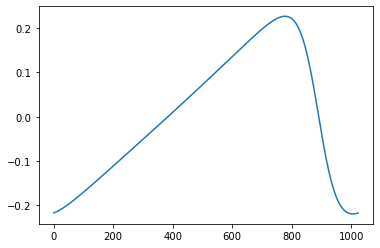

In [9]:
plt.plot(np.arange(1024), burger['output'][1,100, :])

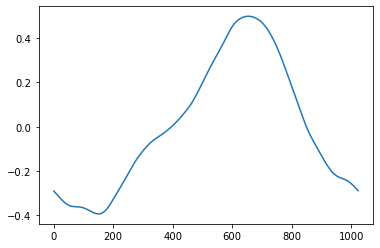

In [8]:
plt.plot(np.arange(1024), burger['output'][1,1, :])

In [10]:
output = burger['output']
sampleSize, timeSize, outSize = output.shape

In [17]:
output[0,:,::8].shape

(101, 128)

In [12]:
all_out = []

In [23]:
data = output[0,:,::8]
out = []
window_size = 10
pred_size = 1
for i in range(len(data) - window_size):
        feature = np.array(data[:, i:i+(window_size)])
        target = np.array(data[:, i+pred_size:i+window_size+pred_size])
        out.append((feature, target))

In [28]:
out[0][].shape

(101, 10)

In [13]:
#!/bin/bash python
import torch 
from torch.utils import tensorboard
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time
from transformer import Tranformer
from utils import *


def process_one_batch(batch_x, batch_y):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        dec_inp = torch.zeros([batch_y.shape[0], 1, batch_y.shape[-1]]).float().to(device)
        dec_inp = torch.cat([batch_y[:,:(window_size-1),:], dec_inp], dim=1).float().to(device)
        outputs = model(batch_x, dec_inp)

        return outputs, batch_y



def evaluate(model,data_loader,criterion):
    model.eval()    
    test_rollout = torch.Tensor(0)   
    test_result = torch.Tensor(0)  
    truth = torch.Tensor(0)
    total_loss = 0.
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    with torch.no_grad():
        for i, (data,targets) in enumerate(data_loader):
            enc_in, dec_in, targets = data.to(device), targets.to(device), targets.to(device)
            output, _ = process_one_batch(enc_in,dec_in)

            total_loss += criterion(output[:,-1:,:], targets[:,-1:,:]).detach().cpu().numpy()
            test_rollout = torch.cat([test_rollout,output[:,-1:,:].detach().cpu()],dim = 1)

    return total_loss, test_rollout[:,-10:,:]

def predict_model(model, test_loader, window_size, epoch, plot=True):
    model.eval()
    test_rollout = torch.Tensor(0)   
    test_result = torch.Tensor(0)  
    truth = torch.Tensor(0)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    with torch.no_grad():
        for i, (data,targets) in enumerate(test_loader):
            if i == 0:
                enc_in = data
                dec_in = targets
                test_rollout = targets
            else:
                enc_in = test_rollout[:,-window_size:,:]
                dec_in = torch.zeros([enc_in.shape[0], 1, enc_in.shape[-1]]).float()
                dec_in = torch.cat([enc_in[:,:(window_size-1),:], dec_in], dim=1).float()
                #dec_in = enc_in[:,:(window_size-1),:]
            enc_in, dec_in, targets = enc_in.to(device), dec_in.to(device), targets.to(device)
            output = model(enc_in, dec_in)
            all_out.append(output)
            test_rollout = torch.cat([test_rollout,output[:,-1:,:].detach().cpu()],dim = 1)
            test_result = torch.cat((test_result, output[:,-1,:].view(-1).detach().cpu()), 0)
            truth = torch.cat((truth, targets[:,-1,:].view(-1).detach().cpu()), 0)
            
    if plot==True:
        fig, ax = plt.subplots(nrows =1, ncols=1, figsize=(20,10))
        ax.plot(test_result,color="red")
        ax.plot(truth,color="blue")
        ax.plot(test_result-truth,color="green")
        ax.grid(True, which='both')
        ax.axhline(y=0, color='k')
        fig.savefig(f'transformer_epoch{epoch}_pred.png')
        plt.close(fig)

class early_stopping():
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.early_stop = False
        self.best_loss = None
        self.counter = 0
        self.best_model = None
    
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss-self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model
        else:
            self.counter += 1 
            if self.counter == self.patience:
                self.early_stop = True
                print('Early stopping')
            print(f'----Current loss {val_loss} higher than best loss {self.best_loss}, early stop counter {self.counter}----')
    
  
    


if __name__ == "__main__":
    #root_dir = '/scratch/zh2095/nyu-capstone/notebooks/turbulence_16/tune_results'
    root_dir = r'C:\Users\curti\scratch\tl2204\tune_results'
    root_dir = ''
    best_config = {'feature_size': 64, 'num_enc_layers': 1, 'num_dec_layers': 1, 'num_head': 2, 'd_ff': 512, 'dropout': 0.1, 'window_size': 10}
    train_proportion = 0.75
    test_proportion = 0.1
    val_proportion = 0.15
    feature_size = best_config['feature_size']
    num_enc_layers = best_config['num_enc_layers']
    num_dec_layers = best_config['num_dec_layers']
    d_ff = best_config['d_ff']
    num_head = best_config['num_head']
    dropout = best_config['dropout']
    lr = 1e-5#best_config['lr']
    window_size = best_config['window_size']
    batch_size = 16#best_config['batch_size']

    model = Tranformer(feature_size=feature_size,num_enc_layers=num_enc_layers,num_dec_layers = num_dec_layers,\
        d_ff = d_ff, dropout=dropout,num_head=num_head)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    print('Using device: ',device)
    model.to(device)
            
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    writer = tensorboard.SummaryWriter('/scratch/tl2204/tensorboard_output/')
    
    # if checkpoint_dir:
    #     checkpoint = os.path.join(checkpoint_dir, "checkpoint")
    #     model_state, optimizer_state = torch.load(checkpoint)
    #     model.load_state_dict(model_state)
    #     optimizer.load_state_dict(optimizer_state)
        
    train_loader, test_loader = get_data_loaders(train_proportion, test_proportion, val_proportion,\
         window_size=window_size, pred_size =1, batch_size=batch_size, num_workers = 2, pin_memory = False, test_mode = True)

    epochs = 10
    train_losses = []
    test_losses = []
    tolerance = 10
    best_test_loss = float('inf')
    Early_Stopping = early_stopping(patience=25)
    for epoch in range(1, epochs + 1):
        model.train() 
        total_loss = 0.
        
        for i,(data, targets) in enumerate(train_loader):

   
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output, truth = process_one_batch(data,targets)
            loss = criterion(output[:,-1,:], targets[:,-1,:])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


        if (epoch%5 == 0):
            print(f'Saving prediction for epoch {epoch}')
            predict_model(model, test_loader, window_size, epoch, plot=True)    


        train_losses.append(total_loss*batch_size)
        test_loss, debug_output = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss/len(test_loader.dataset))


        if epoch==1: ###DEBUG
            print(f'Total of {len(train_loader.dataset)} samples in training set and {len(test_loader.dataset)} samples in test set')


        print(f'Epoch: {epoch}, train_loss: {total_loss*batch_size/len(train_loader.dataset)}, test_loss: {test_loss/len(test_loader.dataset)}, lr: {scheduler.get_last_lr()}')


        Early_Stopping(model, test_loss/len(test_loader))
        if Early_Stopping.early_stop:
            break


        writer.add_scalar('train_loss',total_loss,epoch)
        writer.add_scalar('val_loss',test_loss,epoch)


        if epoch%5 == 0:
            scheduler.step() 


### Plot losses        
    model = Early_Stopping.best_model
    xs = np.arange(len(train_losses))
    fig, ax = plt.subplots(nrows =1, ncols=1, figsize=(20,10))
    ax.plot(xs,train_losses)
    fig.savefig('transformer_train_loss.png')
    plt.close(fig)
    fig, ax = plt.subplots(nrows =1, ncols=1, figsize=(20,10))
    ax.plot(xs,test_losses)
    fig.savefig('transformer_test_loss.png')
    plt.close(fig)
### Predict
    model.eval()
    test_rollout = torch.Tensor(0)   
    test_result = torch.Tensor(0)  
    truth = torch.Tensor(0)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    with torch.no_grad():
        for i, (data,targets) in enumerate(test_loader):
            if i == 0:
                enc_in = data
                dec_in = targets
                test_rollout = targets
            else:
                enc_in = test_rollout[:,-window_size:,:]
                dec_in = torch.zeros([enc_in.shape[0], 1, enc_in.shape[-1]]).float()
                dec_in = torch.cat([enc_in[:,:(window_size-1),:], dec_in], dim=1).float()
                #dec_in = enc_in[:,:(window_size-1),:]
            enc_in, dec_in, targets = enc_in.to(device), dec_in.to(device), targets.to(device)
            output = model(enc_in, dec_in)

            test_rollout = torch.cat([test_rollout,output[:,-1:,:].detach().cpu()],dim = 1)
            test_result = torch.cat((test_result, output[:,-1,:].view(-1).detach().cpu()), 0)
            truth = torch.cat((truth, targets[:,-1,:].view(-1).detach().cpu()), 0)
            
    ### Plot prediction
    fig, ax = plt.subplots(nrows =1, ncols=1, figsize=(20,10))
    ax.plot(test_result,color="red")
    ax.plot(truth,color="blue")
    ax.plot(test_result-truth,color="green")
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    fig.savefig('transformer_pred.png')
    plt.close(fig)

### Check MSE, MAE
    test_result = test_result.numpy()
    truth = truth.numpy()
    MSE = mean_squared_error(truth, test_result)
    MAE = mean_absolute_error(truth, test_result)
    print(f'MSE: {MSE}, MAE: {MAE}')
### Save model result
    test_result_df = pd.DataFrame(test_result)
    test_result_df.to_csv('transformer_prediction.csv')





Using device:  cuda:0


C:\Users\curti\anaconda3\envs\learning\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


Total of 9075 samples in training set and 13 samples in test set
Epoch: 1, train_loss: 0.04397374217667856, test_loss: 3.5715501291213935e-05, lr: [1e-05]
Epoch: 2, train_loss: 0.02185348511563188, test_loss: 1.998481674001176e-05, lr: [1e-05]
Epoch: 3, train_loss: 0.013617920151426773, test_loss: 6.059704985371074e-05, lr: [1e-05]
----Current loss 6.059704985371074e-05 higher than best loss 1.998481674001176e-05, early stop counter 1----
Epoch: 4, train_loss: 0.008922302988114108, test_loss: 1.308357017338634e-05, lr: [1e-05]
Saving prediction for epoch 5
Epoch: 5, train_loss: 0.006800492777804698, test_loss: 4.7063808986754684e-06, lr: [1e-05]
Epoch: 6, train_loss: 0.005260663762401287, test_loss: 0.00010356898173295821, lr: [9.5e-06]
----Current loss 0.00010356898173295821 higher than best loss 4.7063808986754684e-06, early stop counter 1----
Epoch: 7, train_loss: 0.00437298691880276, test_loss: 8.917715548215291e-05, lr: [9.5e-06]
----Current loss 8.917715548215291e-05 higher than 

In [15]:
len(all_out)

26